<a href="https://colab.research.google.com/github/renisio/Classifica-o-de-aprendizagem-profunda-de-doen-as-da-folha-de-Caf-/blob/main/1_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf
import os
import numpy as np
import tensorflow_datasets as tfds

In [ ]:

assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

tpu_address = TF_MASTER

In [ ]:

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
print("Number of devices: ", len(tf.config.list_logical_devices('TPU')))

NameError: ignored

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)


In [ ]:
import tensorflow as tf

# Verificar se a TPU está disponível
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Resolve o nome da TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Conectado a TPU')
except Exception as e:
    print('Erro ao conectar-se à TPU:', str(e))
    strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")  # Caso não haja TPU, use a CPU

# Verificar informações sobre a TPU
print("Número de dispositivos: {}".format(strategy.num_replicas_in_sync))

# Agora você pode criar e treinar modelos TensorFlow dentro deste contexto de TPU.


Conectado a TPU
Número de dispositivos: 8


In [ ]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


# REDE NURAL EfficientNetB0

# Introdução



*  *Importar os pacotes*
*  *Carregar os dados*
* *Visualizar os dados*



In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle -q
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/global-youtube-statistics-2023    Global YouTube Statistics 2023                  60KB  2023-07-28 15:36:38          13278        440  1.0              
nelgiriyewithana/top-spotify-songs-2023            Most Streamed Spotify Songs 2023                47KB  2023-08-26 11:04:57           2566         91  1.0              
iamsouravbanerjee/airline-dataset                  Airline Dataset                                  4MB  2023-08-30 12:03:12           1171         38  1.0              
jjinho/wikipedia-2023-07-faiss-index               Wikipedia 2023 07 faiss index                    5GB  2023-07-17 01:57:37            344         26

In [ ]:
!kaggle datasets download -d noamaanabdulazeem/jmuben-coffee-dataset

100% 771M/773M [00:40<00:00, 21.5MB/s]
100% 773M/773M [00:40<00:00, 20.0MB/s]


In [ ]:
!unzip /content/jmuben-coffee-dataset.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: JMuBEN/Phoma/2 (837).jpg  
  inflating: JMuBEN/Phoma/2 (838).jpg  
  inflating: JMuBEN/Phoma/2 (839).jpg  
  inflating: JMuBEN/Phoma/2 (84).jpg  
  inflating: JMuBEN/Phoma/2 (840).jpg  
  inflating: JMuBEN/Phoma/2 (841).jpg  
  inflating: JMuBEN/Phoma/2 (842).jpg  
  inflating: JMuBEN/Phoma/2 (843).jpg  
  inflating: JMuBEN/Phoma/2 (844).jpg  
  inflating: JMuBEN/Phoma/2 (845).jpg  
  inflating: JMuBEN/Phoma/2 (846).jpg  
  inflating: JMuBEN/Phoma/2 (847).jpg  
  inflating: JMuBEN/Phoma/2 (848).jpg  
  inflating: JMuBEN/Phoma/2 (849).jpg  
  inflating: JMuBEN/Phoma/2 (85).jpg  
  inflating: JMuBEN/Phoma/2 (850).jpg  
  inflating: JMuBEN/Phoma/2 (851).jpg  
  inflating: JMuBEN/Phoma/2 (852).jpg  
  inflating: JMuBEN/Phoma/2 (853).jpg  
  inflating: JMuBEN/Phoma/2 (854).jpg  
  inflating: JMuBEN/Phoma/2 (855).jpg  
  inflating: JMuBEN/Phoma/2 (856).jpg  
  inflating: JMuBEN/Phoma/2 (857).jpg  
  inflating: JMuBEN/Pho

In [ ]:
!pip install  visualkeras
!pip3 install ann_visualizer
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=bc1bd4e6ffa08e92ad5dba891caca5ff2d9ec0f93240fc7200aa58b397d00f31
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


In [ ]:
import pandas as pd # linear algebra
import numpy as np # processamento de dados, E/S de arquivo CSV (por exemplo, pd.read_csv)


import seaborn as sns  #Ele fornece uma interface de alto nível para desenhar gráficos estatísticos atraentes e informativos.
import matplotlib.pyplot as plt #biblioteca para a visualização de dados


import warnings
warnings.filterwarnings('ignore')

from glob import glob #para localizar todos os arquivos em um diretório que correspondem a um determinado padrão.
                      # Os arquivos foram então concatenados em um único dataframe para ser usado para análise posterior
import os  # importar aquivos no sistema operacional
from tqdm import tqdm #seus loops mostrem instantaneamente um medidor de progresso inteligente
import cv2 #sta biblioteca é capaz de processar imagens e vídeos em tempo real, ao mesmo tempo em que possui recursos analíticos


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB0
import visualkeras


# Carregando as imagens

In [ ]:

paths = ['/content/JMuBEN']

total_count = 0
for path in paths:
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    total_count += count

print('Numero total de imagens: {}'.format(total_count))


Numero total de imagens: 58549


In [ ]:
paths = ['/content/JMuBEN/Cerscospora']

total_count = 0
for path in paths:
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    total_count += count

Cerscospora = total_count
result_name = 'Cerscospora'

print('{}: {}'.format(result_name, Cerscospora))

paths = ['/content/JMuBEN/Healthy']

total_count = 0
for path in paths:
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    total_count += count

Healthy = total_count
result_name = 'Healthy'

print('{}: {}'.format(result_name, Healthy))

paths = ['/content/JMuBEN/Leaf rust']

total_count = 0
for path in paths:
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    total_count += count

Leaf_rust = total_count
result_name = 'Leaf_rust'

print('{}: {}'.format(result_name, Leaf_rust))

paths = ['/content/JMuBEN/Miner']

total_count = 0
for path in paths:
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    total_count += count

Miner = total_count
result_name = 'Miner'

print('{}: {}'.format(result_name, Miner))

paths = ['/content/JMuBEN/Phoma']

total_count = 0
for path in paths:
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    total_count += count

Phoma = total_count
result_name = 'Phoma'

print('{}: {}'.format(result_name, Phoma))


Cerscospora: 7681
Healthy: 18983
Leaf_rust: 8336
Miner: 16978
Phoma: 6571


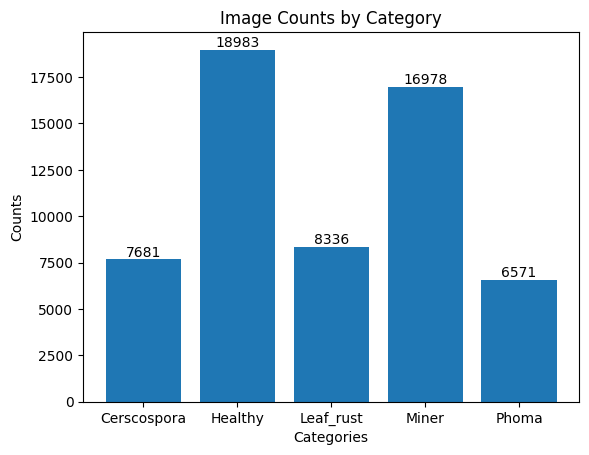

In [ ]:

categories = ['Cerscospora', 'Healthy', 'Leaf_rust', 'Miner', 'Phoma']
counts = [7681, 18983, 8336, 16978, 6571]

fig, ax = plt.subplots()

rects = ax.bar(categories, counts)
ax.set_xlabel('Categories')
ax.set_ylabel('Counts')
ax.set_title('Image Counts by Category')

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, height, ha='center', va='bottom')

plt.show()


# Pré-processamento de dados



*   Armazenar a imagens no X e Classes no Y
*   Embaralhar
*   Dividir o grupo de treino e test
*   Transformar a variavel categorica em binario






In [ ]:
labels = ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']

In [ ]:
# X são os dados e y suas respctiveis clases
X_train = []  # Criando e irei addcionar neste diretorio
y_train = []  # Criando e irei addcionar neste diretorio
image_size = 128 # Alterando o tamanho da imagem por 224 x 224 para cada item do diretorio
for i in labels: # Percorrer cada item do diretorio
    folderPath = os.path.join('/content/JMuBEN',i) # Link para abrir a pasta train
    for j in tqdm(os.listdir(folderPath)): #Faça com que seus loops mostrem instantaneamente um medidor de progresso inteligente
        img = cv2.imread(os.path.join(folderPath,j)) #retorna uma matriz 2D ou 3D com base no número de canais de cores presentes na imagem.
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # Todas imgaens em RGB da pasta train
        img = cv2.resize(img,(image_size, image_size)) # Alterando o tamanho da imagem por 224 x 224 as todas imagens da pasta train
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 6571/6571 [00:03<00:00, 1864.94it/s]


In [ ]:
print("Imagens de treino variavel X", X_train.shape)
print("Imagens de treino variavel y", y_train.shape)

Imagens de treino variavel X (58549, 128, 128, 3)
Imagens de treino variavel y (58549,)


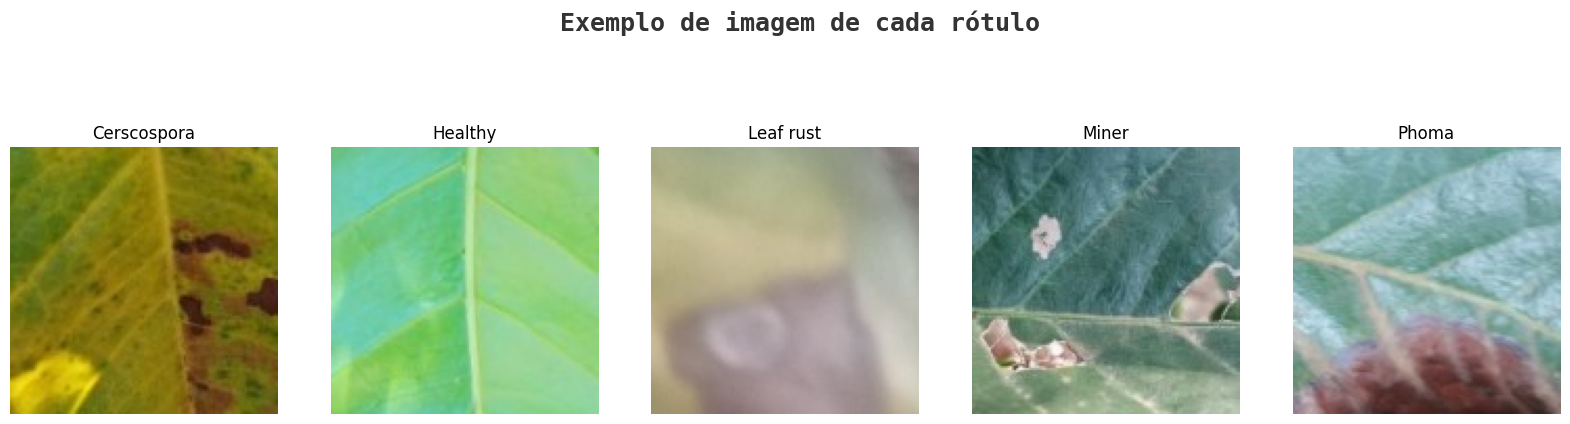

In [ ]:
#  ax criar uma grade de subplots,
#  plt.subplots1,4, linhas e colunas   figsize=(20,20)) tamnhanho

k=0
fig, ax = plt.subplots(1,5,figsize=(20,20))
fig.text(s='Exemplo de imagem de cada rótulo',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
#Embaralhar

# shuffle comumente usada para embaralhar elementos de uma lista antes de usá-los para treinamento de modelos de aprendizado de máquina ou para criar amostras aleatórias de um conjunto de dados.

# random_state=101  Isso significa que, a cada vez que a função é chamada com o mesmo valor para random_state, os mesmos resultados serão gerados.

X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
# serparando os dados de treino e teste, e clases de treino e teste
#train_test_split vai dividir o dataset em treino e teste
#test_size vai seprar para o meus teste a porcentagem
#random_state=101 nivel de aleatoridade, parâmetro controla como os dados são embaralhados antes de serem divididos.


X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)



In [ ]:
#Executando One Hot Encoding nos rótulos após convertê-lo em valores numéricos\

#One Hot Encoding é uma representação de variáveis ​​categóricas como vetores binários.
       #Podemos atribuir a 'vermelho' um valor inteiro de 0 e 'verde' o valor inteiro de 1.

#One-hot encoding é um processo de codificação de dados categóricos, onde uma variável categórica
#é convertida em um vetor binário com uma única posição a 1 e as demais a 0. Isso é útil quando
#se está trabalhando com algoritmos de aprendizado de máquina que não podem lidar diretamente com
# variáveis categóricas, pois esses algoritmos geralmente esperam valores numéricos.

y_train_new = []
for i in y_train: #para  [item]  em  [sequência] : Execute o  código
    y_train_new.append(labels.index(i)) # adcionou no y_train_new o vetor de as clases do y_train
y_train = y_train_new # o y_train agora é y_train_new
y_train = tf.keras.utils.to_categorical(y_train) #converter o vetor y_train de classe na matriz da classe binária

# igual de linhas do comprimento do vetor de entrada e o número da coluna que é igual ao número da classe que definimos em nosso código

y_test_new = []
for i in y_test: #para  [item]  em  [sequência] : Execute o  código
    y_test_new.append(labels.index(i)) #adcionou no y_train_new o vetor de as clases do y_train
y_test = y_test_new # o y_train agora é y_train_new
y_test = tf.keras.utils.to_categorical(y_test)  #converter o vetor y_test de classe na matriz da classe binária



In [ ]:
print("Imagens de Treino variavel X", X_train.shape)
print("Imagens de Treino variavel y", y_train.shape)
print("Imagens de Teste variavel X", X_test.shape)
print("Imagens de Teste variavel y", y_test.shape)

Imagens de Treino variavel X (37471, 128, 128, 3)
Imagens de Treino variavel y (37471, 5)
Imagens de Teste variavel X (9368, 128, 128, 3)
Imagens de Teste variavel y (9368, 5)


# Rede Neural Trans Learning :EfficientNetB0

In [ ]:
#Definir o modelo (definir o total de camada , quantas neuronios cada camada tera, as funçoes de ativiação e como as camadas se interconectam )

efficientNet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
efficientNet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

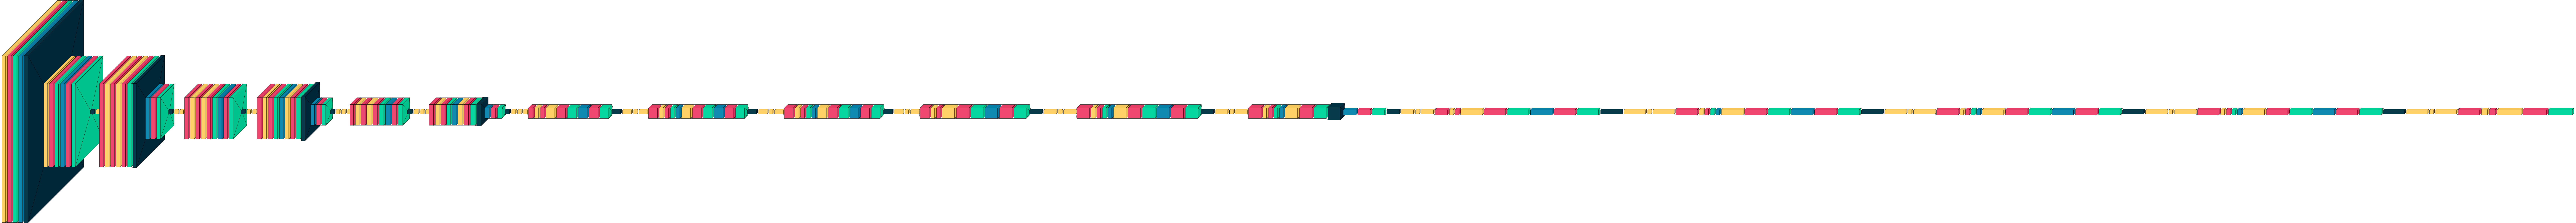

In [ ]:
visualkeras.layered_view(efficientNet)

In [ ]:
numberOfClass = 5

In [ ]:
# Cria o modelo personalizado

model = efficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(numberOfClass,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientNet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

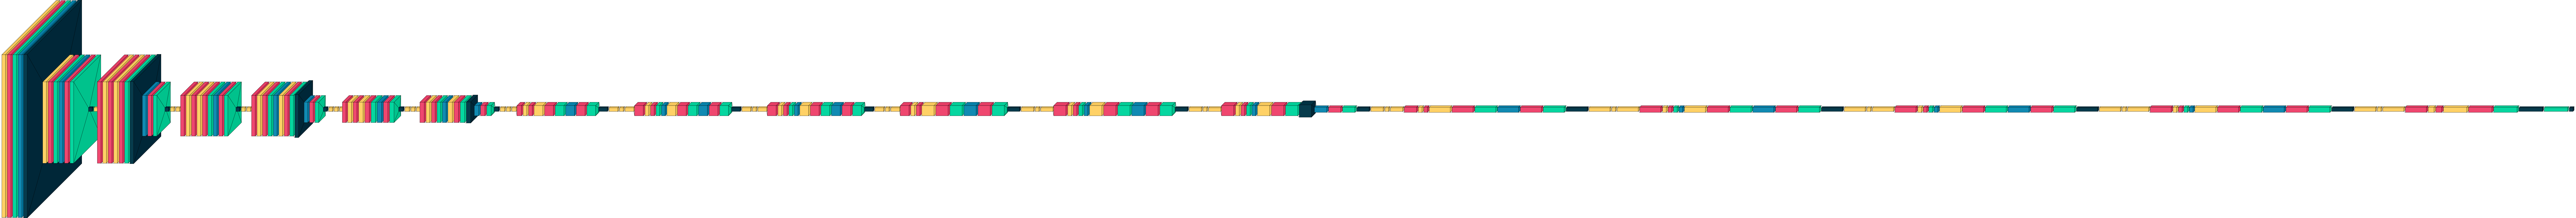

In [ ]:
visualkeras.layered_view(model)

In [ ]:
#Hyperparametros

#O otimizador é uma parte crucial do treinamento de uma rede neural. Ele é responsável
#por ajustar os pesos da rede ao longo do tempo para que a função de perda seja minimizada.
#Em outras palavras, o otimizador é o que permite que o modelo aprenda a partir dos dados.


#Compilar o modelo (definir o algoritimo a computar os gradientes, as metricas capazes de avaliar erros, e a função de erro  )

model.compile(loss='categorical_crossentropy', # A função de perda vai calcular o tanto que a rede esta errando, a diferença do resultado ideal com quanto a rede esta oferencendo na pratica,,
                                               # Saida é uma probalidade. Usado como uma função de perda para o modelo de classificação multiclasse onde há dois ou mais rótulos de saída.
              optimizer = 'Adam', # Quem vai fazer os calculos para ajustar os pessos da rede neural
              metrics= ['accuracy']) # A precisão é uma medida de quão bem o modelo está realizando suas previsões e é uma das métricas mais comuns usadas para avaliar o desempenho de um modelo de classificação

In [ ]:
#TensorBoard: medidas e visualizações necessárias durante o fluxo de trabalho de aprendizado de máquina.
             # Ele permite rastrear métricas de experimentos como perda e precisão, visualizar o gráfico do modelo

#ModelCheckpoint : salvar um modelo ou pesos (em um arquivo de ponto de verificação) em algum intervalo,
                  #para que o modelo ou os pesos possam ser carregados posteriormente para continuar o treinamento a partir do estado salvo.
                  #save_best_only = Salvar o melhor modelo #verbose= mostra a barra de progresso #mode = queremos monitorar o "val_accurracy

#ReduceLROnPlateau:  Este retorno de chamada monitora uma quantidade e se nenhuma melhora for observada por um número de 'paciência'
                     # de épocas, a taxa de aprendizado é reduzida

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("CovidModelEfficientNet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', #monitor = metrica a ser monitorada
                              factor = 0.1, #fator pelo qual a taxa de aprendizado será reduzida.
                              patience = 2, #número de épocas sem melhora após as quais a taxa de aprendizado será reduzida.
                              min_delta = 0.001, #limite para medir o novo ótimo, para focar apenas em mudanças significativas.
                              mode='auto',verbose=1) # verbose= mostra a barra de progresso, mode = queremos monitorar o "val_accurracy" queremo valor maximo

In [ ]:
batch_size   = 32
input_shape  = (128,128,3)
random_state = 42
alpha        = 1e-5
epoch        = 25

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)
tensorboard = TensorBoard(log_dir = 'logs')

callbacks = [checkpoint, lr_reduce, tensorboard]


# Treianando a rede neural

In [ ]:
# Fazendo a rede aprender na pratica

hist = model.fit(X_train,
                 y_train,
                 validation_split=0.1,
                 epochs =7, # 15  epocas
                 verbose=1, #mostra a barra de progresso
                 batch_size=32, # configura  a  quantidade  de imagens por lote no processamento, Vai processar de 32 imagens por vez
                  callbacks=[tensorboard,checkpoint,reduce_lr] # definidos anteriormente
                 )

Epoch 1/7
1054/1054 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9839

1054/1054 [==============================] - 160s 96ms/step - loss: 0.0520 - accuracy: 0.9839 - val_loss: 0.0073 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 2/7
1054/1054 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9942

1054/1054 [==============================] - 99s 93ms/step - loss: 0.0210 - accuracy: 0.9942 - val_loss: 0.0625 - val_accuracy: 0.9872 - lr: 0.0010
Epoch 3/7
1054/1054 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9947


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1054/1054 [==============================] - 97s 92ms/step - loss: 0.0176 - accuracy: 0.9947 - val_loss: 0.0074 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 4/7
1054/1054 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9993

1054/1054 [==============================] - 98s 93ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 1.8762e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/7
1054/1054 [==============================] - ETA: 0s - loss: 7.2591e-04 - accuracy: 0.9999

1054/1054 [==============================] - 97s 92ms/step - loss: 7.2591e-04 - accuracy: 0.9999 - val_loss: 5.9883e-06 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/7
1054/1054 [==============================] - ETA: 0s - loss: 5.3043e-04 - accuracy: 0.9999


Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1054/1054 [==============================] - 98s 93ms/step - loss: 5.3043e-04 - accuracy: 0.9999 - val_loss: 3.7930e-06 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/7
1054/1054 [==============================] - ETA: 0s - loss: 1.7763e-04 - accuracy: 1.0000

1054/1054 [==============================] - 97s 92ms/step - loss: 1.7763e-04 - accuracy: 1.0000 - val_loss: 2.7747e-06 - val_accuracy: 1.0000 - lr: 1.0000e-05


# Resulatados da rede neural

In [ ]:
results = model.evaluate(X_train,y_train)

1171/1171 [==============================] - 27s 23ms/step - loss: 2.4335e-06 - accuracy: 1.0000


In [ ]:
results2 = model.evaluate(X_test,y_test)

293/293 [==============================] - 7s 25ms/step - loss: 2.7737e-06 - accuracy: 1.0000


In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


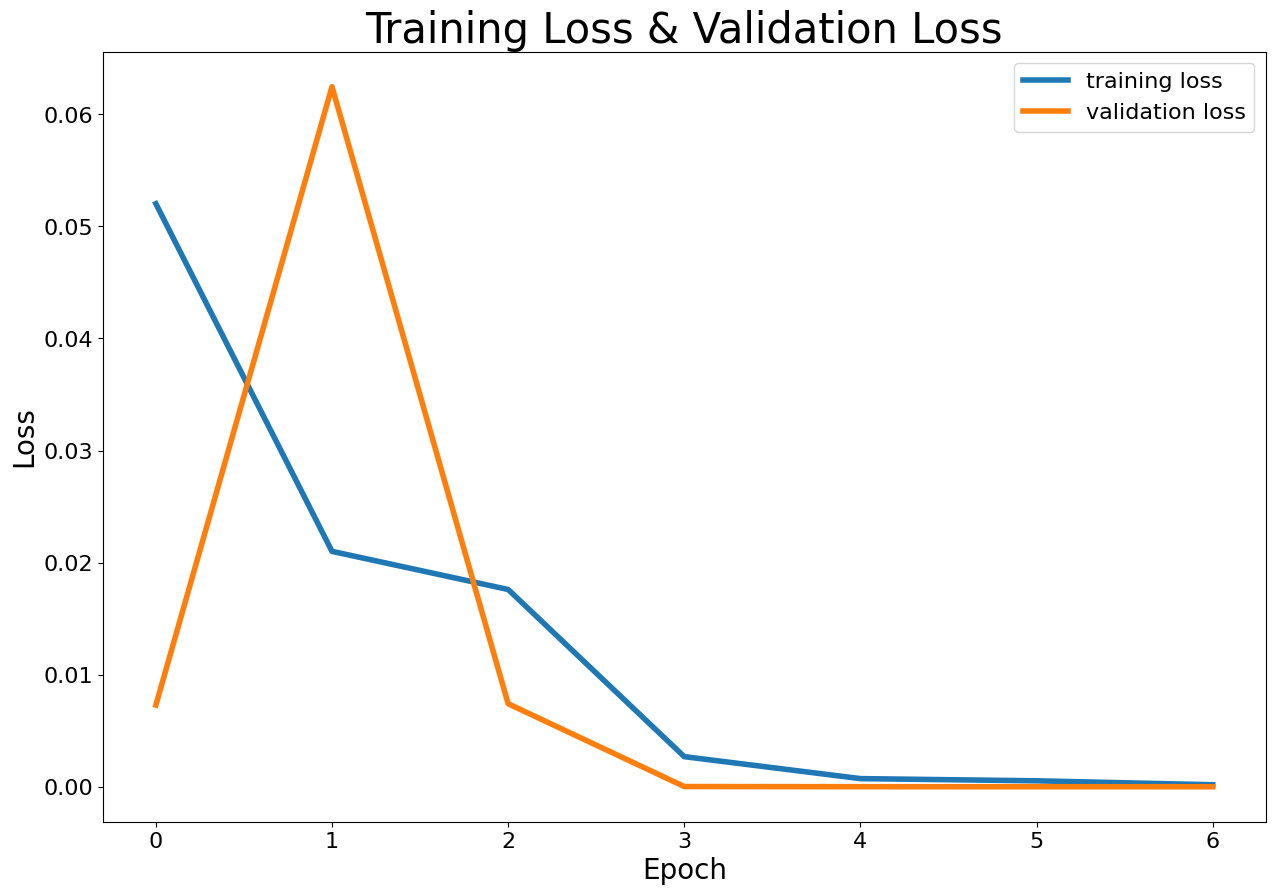

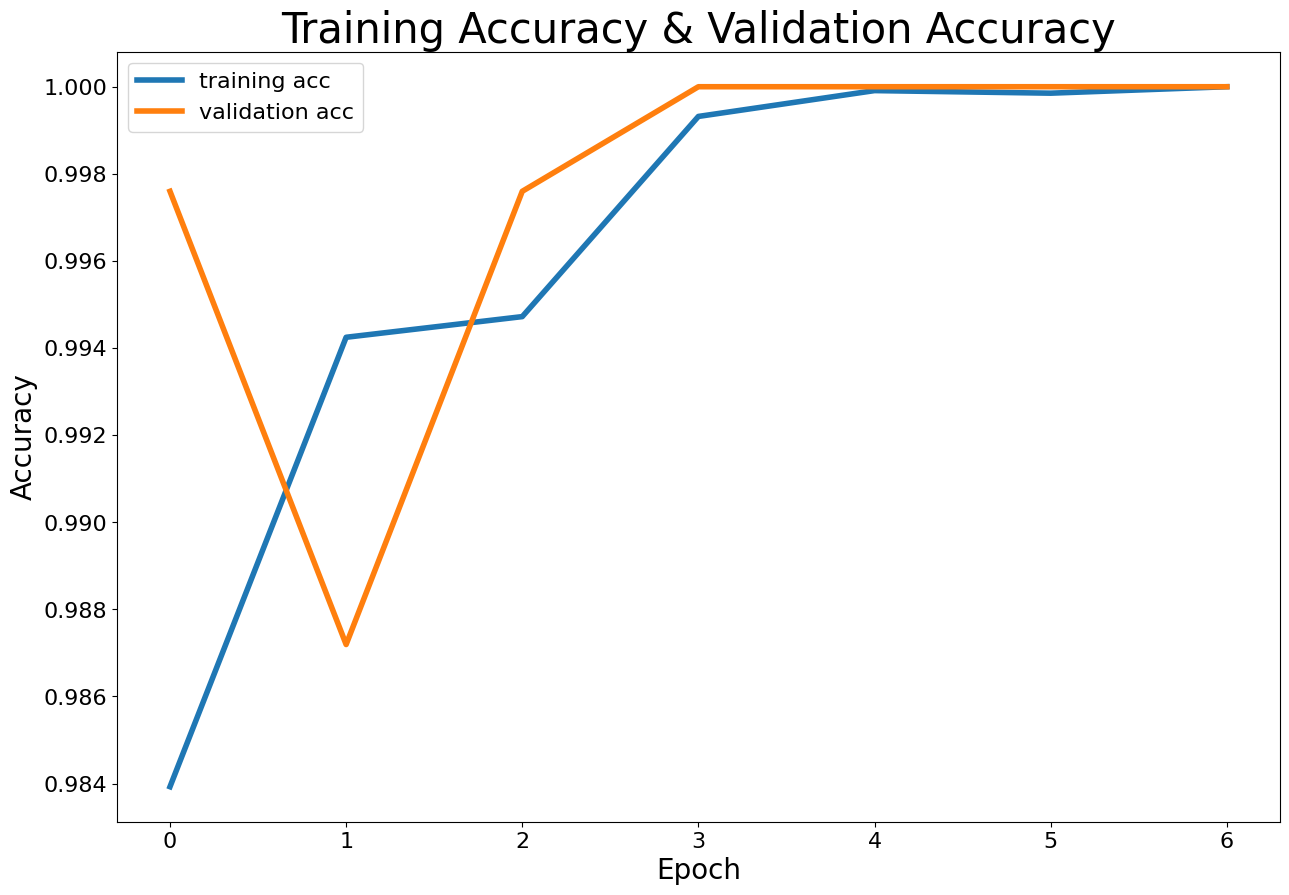

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(hist.history["loss"],label = "training loss", linewidth=4)
plt.plot(hist.history["val_loss"],label = "validation loss", linewidth=4)
plt.title("Training Loss & Validation Loss", fontsize=30)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(15,10))
plt.plot(hist.history["accuracy"],label = "training acc", linewidth=4)
plt.plot(hist.history["val_accuracy"],label = "validation acc", linewidth=4)
plt.title("Training Accuracy & Validation Accuracy", fontsize=30)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

293/293 [==============================] - 7s 20ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1239
           1       1.00      1.00      1.00      3078
           2       1.00      1.00      1.00      1341
           3       1.00      1.00      1.00      2726
           4       1.00      1.00      1.00       984

    accuracy                           1.00      9368
   macro avg       1.00      1.00      1.00      9368
weighted avg       1.00      1.00      1.00      9368



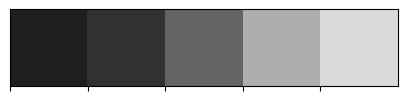

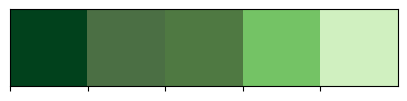

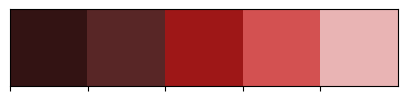

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

[[1239    0    0    0    0]
 [   0 3078    0    0    0]
 [   0    0 1341    0    0]
 [   0    0    0 2726    0]
 [   0    0    0    0  984]]


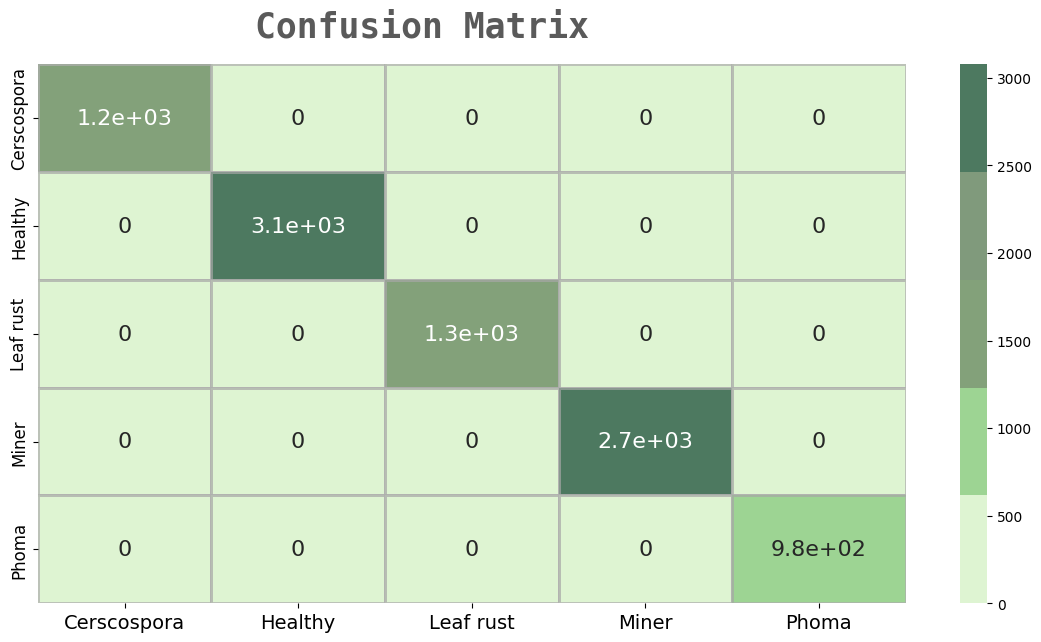

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))

sns.heatmap(confusion_matrix(y_test_new, pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,
            linewidths=2,
            linecolor=colors_dark[3],
            annot_kws={"fontsize": 16}, # tamanho da fonte dos resultados
            )
ax.tick_params(axis='both', which='major', labelsize=14) # tamanho da fonte dos eixos x e y
ax.set_xticklabels(labels, fontsize=14) # tamanho da fonte das barras laterais x
ax.set_yticklabels(labels, fontsize=12) # tamanho da fonte das barras laterais y
fig.text(s='Confusion Matrix',
         size=25,
         fontweight='bold',
         fontname='monospace',
         color=colors_dark[1],
         y=0.92,
         x=0.28,
         alpha=0.8)
print(confusion_matrix(y_test_new,pred))
plt.show()

[[1239    0    0    0    0]
 [   0 3078    0    0    0]
 [   0    0 1341    0    0]
 [   0    0    0 2726    0]
 [   0    0    0    0  984]]


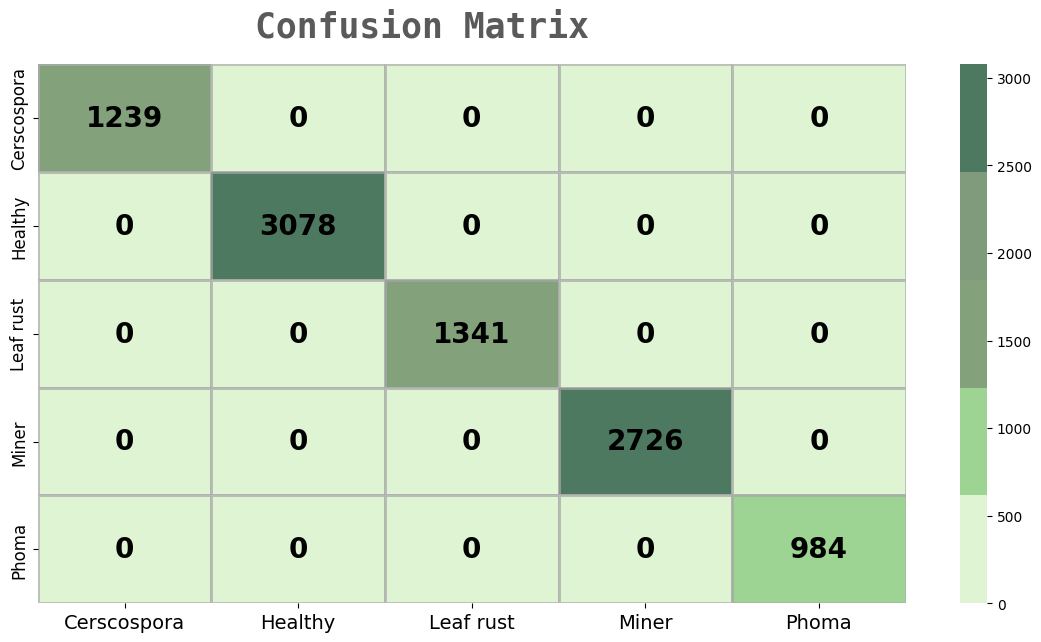

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))

sns.heatmap(confusion_matrix(y_test_new, pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,
            linewidths=2,
            linecolor=colors_dark[3],
            annot_kws={"fontsize": 20, "fontweight": "bold", "color": "black"},
            fmt=".0f"
            )
ax.tick_params(axis='both', which='major', labelsize=14) # tamanho da fonte dos eixos x e y
ax.set_xticklabels(labels, fontsize=14) # tamanho da fonte das barras laterais x
ax.set_yticklabels(labels, fontsize=12) # tamanho da fonte das barras laterais y
fig.text(s='Confusion Matrix',
         size=25,
         fontweight='bold',
         fontname='monospace',
         color=colors_dark[1],
         y=0.92,
         x=0.28,
         alpha=0.8)
print(confusion_matrix(y_test_new,pred))
plt.show()

# Baixando os resultados para fazer assemble

In [ ]:
# obter as previsões para cada imagem de teste
y_pred = model.predict(X_test)

# obter a classe prevista para cada imagem de teste (classe com maior probabilidade)
y_pred_classes = y_pred.argmax(axis=-1)

# armazenar as previsões em uma matriz
predictions = y_pred_classes.reshape(-1, 1)

import pandas as pd

# criar um DataFrame a partir da matriz de previsões
df_predictions = pd.DataFrame(predictions, columns=['Predicted Class'])

# imprimir o DataFrame
print(df_predictions)

293/293 [==============================] - 6s 19ms/step
      Predicted Class
0                   0
1                   3
2                   3
3                   2
4                   0
...               ...
9363                4
9364                3
9365                2
9366                1
9367                4

[9368 rows x 1 columns]


In [ ]:
from google.colab import files
import pandas as pd

# criar um DataFrame a partir da matriz de previsões
df_predictions = pd.DataFrame(predictions, columns=['Predicted Class'])

# salvar o DataFrame em um arquivo Excel
df_predictions.to_excel('predictions.xlsx', index=False)

# baixar o arquivo para o seu computador
files.download('predictions.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

# Encontra o índice do valor máximo em cada linha da matriz
y_test_pred = np.argmax(y_test, axis=1)

# Transforma o vetor unidimensional em um vetor coluna
y_test_pred_col = y_test_pred.reshape(-1, 1)

from google.colab import files

# Transforma o vetor unidimensional em um vetor coluna
y_test_pred_col = y_test_pred.reshape(-1, 1)

# Cria um DataFrame a partir do vetor coluna
df_y_test_pred = pd.DataFrame(y_test_pred_col, columns=['Predicted Class'])

# Escreve o DataFrame em um arquivo Excel
filename = 'y_test_pred.xlsx'
df_y_test_pred.to_excel(filename, index=False)

# Baixa o arquivo Excel para o computador
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>